# Notebook for the reproduction of results in [Randomized Linear Gate Set Tomography](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.030328).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Import my own modules
from src import quantum_utilities as qu
from src import randomized_linear_gst as rlgst

# Import Qiskit basics
from qiskit import QuantumCircuit
from qiskit import Aer, transpile, execute
from qiskit.tools.visualization import plot_histogram

# Import from QiskitAer noise module
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error, amplitude_damping_error, coherent_unitary_error
from qiskit.providers.aer.noise import depolarizing_error

# Import Quantum Information module
import qiskit.quantum_info as qi


In [2]:
%matplotlib inline

## Build noise model

Define initial parameters for you QC system and the error model, as well as the error magnitude.

In [3]:
num_qubits = 1
d2 = 2**(2*num_qubits)
native_gate_list = ['I', 'Xpi2', 'Ypi2']

error_scale = 1*(10**(-4))


rng = np.random.default_rng(2703)
b_elem = np.array([0,1])

# create list of native gate operations as numpy array
Xpi2 = qu.get_rotation_gate(np.pi/2,'x')
Ypi2 = qu.get_rotation_gate(np.pi/2,'y')
native_gate_op = [np.eye(2), Xpi2, Ypi2]
native_gate_channels = [qu.gate_to_channelmatrix(G) for G in native_gate_op]


def noise_model(e_vec):
    NM = np.eye(4)
    NM = np.dot(qu.get_rotation_channel(e_vec[6],'z'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[5],'y'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[4],'x'),NM)
    NM = np.dot(qu.get_Pauli_channel2(e_vec[1],e_vec[2],e_vec[3]),NM)
    NM = np.dot(qu.get_AD_channel2(e_vec[0]),NM)
    return(NM)

noisy_native_gate_channels = [noise_model(rng.random(7)*error_scale)@gate for gate in native_gate_channels]



def linear_noise_model(e_vec):
    return( np.eye(4) + np.vstack( (np.zeros((1,4)), e_vec.reshape(3,4) )   ) )


# noisy_native_gate_channels = [linear_noise_model(rng.random(12)*error_scale)@gate for gate in native_gate_channels]


In [4]:
print('AGsI:')
print(np.real(qu.AGsI(native_gate_channels, noisy_native_gate_channels)))

AGsI:
0.00011382822564835286


Now we will setup initial state and measurement error. Notice that, chosing as POVM $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(X + Y - Z)$ will only affect the measurement in Z basis as $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(- Z)$, i.e. with a mis-reading equal to $\frac{a}{\sqrt{2}}$ for both $P(1|0)$ and $P(0|1)$.

In [5]:
# build initial state \rho_in and POVMs
a = 0.01
#a = np.real(qu.AGsI(native_gate_channels, noisy_native_gate_channels))


rho_in = np.array([[1, 0],[0, 0]], dtype = np.complex_) + a/np.sqrt(2) * ( qi.Pauli('X').to_matrix() + qi.Pauli('Y').to_matrix() - qi.Pauli('Z').to_matrix())

P0 = rho_in # set measurement POVM
P1 = np.array([[1, 0],[0, 1]], dtype = np.complex_) - P0

rho_dirac = qu.superket(rho_in)
P0_dirac = qu.superbra(P0)
P1_dirac = qu.superbra(P1)

## Sample circuits of intrest

Each circuit will be a list of integers from $1$ to $|\mathcal{G}|$. They will be then arranged into a list of lists, grouping per depth.
NOTE: duplicate circuits have to be discarded.

In [6]:
L_list = [8, 16, 32, 64, 128]
#L_list = [8,16,32]
Nc = 187
#Nc = 24
Nshots = 8192


circuit_list = []
circuit_list.append([])
for l in range(len(L_list)):
    circuits = []
    for i in range(Nc):
        c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist() 
        while c in circuits:
            c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist()
        circuits.append(c)
    circuit_list.append(circuits)

    
Nc_tot = 1 + len(L_list)*Nc
L_list = [0] + L_list


## Compute $\tilde{p}$ and $p$ and build $\mathbf{C}$
Ideal probabilities can be retrived from the same method that builds $\mathbf{C}$. Noisy probabilities have to be simulated apart.

In [7]:
p_noisy = np.zeros((Nc_tot,1))
p_true = np.zeros((Nc_tot,1))
ne_param = len(native_gate_channels)*d2*(d2-1)+2*d2-1
C = np.zeros((Nc_tot, ne_param))

j = 1
p_noisy[0] = qu.my_braket([P0_dirac,rho_dirac]) # null circuit
C[0],p_true[0] = rlgst.get_C_coeff([],native_gate_channels)


for l in range(1,len(L_list)):
    for c in circuit_list[l]:
        C[j],p_true[j] = rlgst.get_C_coeff(c,native_gate_channels)
        gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
        gate_list.insert(0,P0_dirac)
        gate_list.append(rho_dirac)
        p_noisy[j] = (Nshots - np.sum(np.random.choice(b_elem, Nshots, p =  [qu.my_braket(gate_list)[0,0],1-qu.my_braket(gate_list)[0,0]] )))/Nshots
        j+=1    


## Estimate error $\hat{e}$

In [8]:
# compute C (pseudo)inverse
C_limited = C
tol = 1e-15
C_limited[np.abs(C_limited.real) < tol] = 0.0
#C_limited.imag[abs(C_limited.imag) < tol] = 0.0

V, C_eig, WH = np.linalg.svd(C_limited, full_matrices=False)
threshold = Nc_tot*np.finfo(float).eps*C_eig.max()
print(threshold)

inv_diag = [1/lambda_ if np.abs(lambda_) >= threshold else 0 for lambda_ in C_eig]

C_inv = WH.conjugate().T @ np.diag(inv_diag) @ V.conjugate().T # right inverse of C

# estimate e
e = C_inv@(p_noisy-p_true)


3.9723012095453676e-11


In [9]:
print(inv_diag)

[0.005232074287579416, 0.011515782227458922, 0.016408798753426594, 0.01929790676806804, 0.021205366110871635, 0.02196811254298929, 0.026020717339707483, 0.026556548692665615, 0.028233444719375705, 0.029566247430906963, 0.0304790285470148, 0.03287844817878597, 0.037628654015343814, 0.03917620826434321, 0.041597743667811035, 0.042845543790494364, 0.044300672636866545, 0.04717961288695468, 0.04781288466017855, 0.04853270179675906, 0.04935973350478818, 0.04978146099253692, 0.05077070455863892, 0.052077885218900374, 0.05324461588822888, 0.06129906183273603, 0.06606755849917037, 0.07173140859057892, 0.07621601761838301, 0.0820781766972743, 0.08506896327091383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Analyze $\mathbf{C}$ matrix.

Extract noisy maps from $e$.

In [10]:
#err_list = []
est_noisy_gate_channels = []

for i in range(len(native_gate_channels)):
    e_i = np.eye(4) + np.vstack(( np.zeros((1,4)), e[i*12:(i+1)*12].reshape(3,4)))
    print(e_i)
    #err_list.append(e_i)
    est_noisy_gate_channels.append(e_i@native_gate_channels[i])
    
rho_est = qu.superket(np.array([[1, 0],[0, 0]], dtype = np.complex_)) +  np.vstack( (np.array([0]), e[len(native_gate_channels)*12:len(native_gate_channels)*12+3]) )
P0_est = qu.superbra(np.array([[1, 0],[0, 0]], dtype = np.complex_)) + e[len(native_gate_channels)*12+3:].conjugate().T

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.98643940e-05  9.99820924e-01  1.77495675e-05  2.61879682e-04]
 [ 3.34357172e-05 -2.10605087e-04  9.99710263e-01 -1.77200368e-04]
 [ 1.36029775e-04 -1.30149203e-04 -1.89057420e-04  9.99880977e-01]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.09175443e-05  9.99750165e-01 -2.43985300e-03 -2.40218720e-03]
 [-1.23826239e-03  2.78640238e-03  9.99877129e-01 -5.25648958e-05]
 [ 3.98827787e-03  2.48812355e-03  2.06641366e-04  9.99877129e-01]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.56339138e-03  9.99739367e-01 -2.77718648e-03  2.05367333e-04]
 [-1.58449115e-04  2.54116895e-03  9.99697624e-01 -2.83944778e-03]
 [-6.86100016e-04  3.87181472e-04  2.81485228e-03  9.99739367e-01]]


In [11]:
i=2
print(np.vstack(( np.zeros((1,4)), e[i*12:(i+1)*12].reshape(3,4))))
print(native_gate_channels[i])

[[ 0.          0.          0.          0.        ]
 [-0.00356339 -0.00026063 -0.00277719  0.00020537]
 [-0.00015845  0.00254117 -0.00030238 -0.00283945]
 [-0.0006861   0.00038718  0.00281485 -0.00026063]]
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]]


In [12]:
print(rho_dirac)
print(rho_est)
print(P0_dirac)
print(P0_est)

[[0.70710678]
 [0.01      ]
 [0.01      ]
 [0.69710678]]
[[0.70710678]
 [0.00600969]
 [0.00739144]
 [0.69763763]]
[[0.70710678 0.01       0.01       0.69710678]]
[[0.70559584 0.0082973  0.00812623 0.69763763]]


## Run test-set circuits

In [13]:
L_test_list = [10, 50, 100, 200, 500, 1000]
Nc_test = 1000

Nc_test_tot = len(L_test_list)*Nc_test

N_it = 10

delta = np.zeros((N_it,len(L_test_list)))

for it in range(N_it):
    delta_it = []
    circuit_test_list = []
    for l in range(len(L_test_list)):
        circ = [rng.integers(low=0, high= len(native_gate_list), 
                             size=L_test_list[l]).tolist() for i in range(Nc_test)] 

        p_test_true_l = np.zeros((Nc_test,1))  # true noisy p
        p_test_est_l = np.zeros((Nc_test,1)) # estimated p
        j = 0
       
        for c in circ:
            true_gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
            true_gate_list.insert(0,P0_dirac)
            true_gate_list.append(rho_dirac)

            est_gate_list = [est_noisy_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list.insert(0,P0_est)
            est_gate_list.append(rho_est)

            p_test_true_l[j] = qu.my_braket(true_gate_list)[0,0]
            p_test_est_l[j] = qu.my_braket(est_gate_list)[0,0]
            j+=1 
        
        delta_it.append(np.linalg.norm((p_test_true_l - p_test_est_l),ord=1)/Nc_test)
    print(delta_it)
    delta[it] = np.array(delta_it)


delta_mean = np.mean(delta,axis=0)


[0.000509515697864163, 0.0005876800447481866, 0.0010140086681164387, 0.0019734498436995464, 0.0049622803273084645, 0.010568068602746386]
[0.0005106621906532906, 0.0006288243442965245, 0.0010030635168249238, 0.0019373449628466114, 0.0051064934220929415, 0.010656326446803916]
[0.0005112287443226484, 0.00061344223901, 0.0010235594777556717, 0.0019146232538073073, 0.005097224435517847, 0.010527510488944212]
[0.0005001294852271315, 0.000643291626778946, 0.0009593083946212732, 0.0018878880536917796, 0.005163619435411125, 0.010734509658540104]
[0.0005002766672301917, 0.0006135859185681303, 0.0009430025673312096, 0.001895301540114194, 0.005061989317715987, 0.010517880732663453]
[0.0005015048515271877, 0.0006368910277789332, 0.0010055352038203789, 0.001966456354697512, 0.00508410577130853, 0.010648782610925327]
[0.0005189948893318016, 0.000637331765327411, 0.0009710781630136822, 0.0019225054147404505, 0.0050960037533353065, 0.010499042310033686]
[0.000506154721540246, 0.0006140202124573426, 0.0

In [14]:
print(qu.my_braket(true_gate_list))
print(qu.my_braket(est_gate_list))
[print(g) for g in est_noisy_gate_channels]

[[0.47783983]]
[[0.48946593]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.98643940e-05  9.99820924e-01  1.77495675e-05  2.61879682e-04]
 [ 3.34357172e-05 -2.10605087e-04  9.99710263e-01 -1.77200368e-04]
 [ 1.36029775e-04 -1.30149203e-04 -1.89057420e-04  9.99880977e-01]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.09175443e-05  9.99750165e-01 -2.40218720e-03  2.43985300e-03]
 [-1.23826239e-03  2.78640238e-03 -5.25648958e-05 -9.99877129e-01]
 [ 3.98827787e-03  2.48812355e-03  9.99877129e-01 -2.06641366e-04]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.56339138e-03 -2.05367333e-04 -2.77718648e-03  9.99739367e-01]
 [-1.58449115e-04  2.83944778e-03  9.99697624e-01  2.54116895e-03]
 [-6.86100016e-04 -9.99739367e-01  2.81485228e-03  3.87181472e-04]]


[None, None, None]

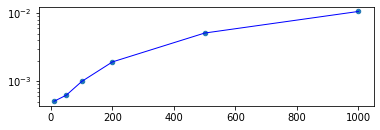

In [15]:
plt.figure()
plt.subplot(211)
plt.plot(L_test_list, delta_mean, 'b', lw=1)
plt.scatter(L_test_list, delta_mean, s=20)
plt.yscale("log")
plt.show()

# Standard GST section

In [16]:
import pygsti
from pygsti.circuits import Circuit
from pygsti.circuits.circuitparser import CircuitParser
from pygsti.models import Model
from pygsti.data import DataSet
from pygsti.modelpacks import smq1Q_XYI
import pygsti.modelmembers as mm

In [17]:
#Initialize an empty Model object
#Designate the basis being used for the matrices and vectors below 
# as the "Pauli product" basis of dimension 2 - i.e. the four 2x2 Pauli matrices I,X,Y,Z
mdl_noisy = pygsti.models.ExplicitOpModel((0,),'pp')

#Populate the Model object with states, effects, gates,
# all in the *normalized* Pauli basis: { I/sqrt(2), X/sqrt(2), Y/sqrt(2), Z/sqrt(2) }
# where I, X, Y, and Z are the standard Pauli matrices.
mdl_noisy['rho0'] = rlgst.flatten(rho_dirac) # noisy init density matrix
mdl_noisy['Mdefault'] = mm.povms.UnconstrainedPOVM(
    {'0': rlgst.flatten(P0_dirac),   # projector onto [[1, 0], [0, 0]] in Pauli basis
     '1': rlgst.flatten(qu.superket(P1)) },# projector onto [[0, 0], [0, 1]] in Pauli basis
    evotype='densitymx') # Specify the evolution type when initializing from NumPy arrays.
                         # densitymx is the default

mdl_noisy['Gi'] = noisy_native_gate_channels[0].tolist() # 4x4 identity matrix, noisy
mdl_noisy['Gx'] = noisy_native_gate_channels[1].tolist() # pi/2 X-rotation in Pauli basis, noisy
mdl_noisy['Gy'] = noisy_native_gate_channels[2].tolist() # pi/2 Y-rotation in Pauli basis, noisy

In [18]:
# 1) get the target Model
mdl_ideal = smq1Q_XYI.target_model()


# 2) get the building blocks needed to specify which circuits are needed
prep_fiducials, meas_fiducials = smq1Q_XYI.prep_fiducials(), smq1Q_XYI.meas_fiducials()
germs = smq1Q_XYI.germs()

maxLengths = [2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7]
#lsgst_lists = pygsti.circuits.create_lsgst_circuit_lists(mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

#listOfExperiments = pygsti.circuits.create_lsgst_circuits(mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)
exp_design = pygsti.protocols.StandardGSTDesign(mdl_ideal, prep_fiducials, meas_fiducials,
                                                germs, maxLengths)

In [19]:
def simulate_taking_data(noisy_native_gate_channels,rho_noisy, P0_noisy, P1_noisy, data_template_filename):
    """Simulate taking 1-qubit data and filling the results into a template dataset.txt file"""
    mdl_noisy = pygsti.models.ExplicitOpModel((0,),'pp')
    mdl_noisy['rho0'] = rho_noisy
    mdl_noisy['Mdefault'] = mm.povms.UnconstrainedPOVM(
        {'0': P0_noisy,   
         '1': P1_noisy },
        evotype='densitymx') 

    mdl_noisy[()] = noisy_native_gate_channels[0]
    mdl_noisy[('Gxpi2', 0)] = noisy_native_gate_channels[1]
    mdl_noisy[('Gypi2', 0)] = noisy_native_gate_channels[2]
    
    pygsti.io.fill_in_empty_dataset_with_fake_data(mdl_noisy, data_template_filename, num_samples=8192, seed=2703)

In [20]:
pygsti.io.write_empty_protocol_data( '../data/GST_data', exp_design, clobber_ok=True)

# -- fill in the dataset file in tutorial_files/test_gst_dir/data/dataset.txt --
simulate_taking_data(noisy_native_gate_channels, rho_dirac.T[0], P0_dirac[0], P1_dirac[0], "../data/GST_data/data/dataset.txt")  # REPLACE with actual data-taking

gst_data = pygsti.io.read_data_from_dir('../data/GST_data')

/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/pyGSTi/pygsti/io/writers.py:623: UserWarning: fill_in_empty_dataset_with_fake_data has recently changed its signature - it looks like you need to swap the first two arguments.  Continuing using the old signature...
  _warnings.warn(("fill_in_empty_dataset_with_fake_data has recently changed its signature - it looks like"
/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/pyGSTi/pygsti/data/datasetconstruction.py:236: UserWarning: Adjusting sum(probs) = 1 < 1 to 1
  _warnings.warn("Adjusting sum(probs) = %g < 1 to 1" % psum)
/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/pyGSTi/pygsti/data/datasetconstruction.py:244: UserWarning: Adjustment finished
  _warnings.warn('Adjustment finished')
/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/pyGSTi/pygsti/data/datasetconstruction.py:236: UserWarning: Adjusting sum(probs) = 0.999968 < 1 to 1
  _warnings.warn("Adjusting sum(probs) = %g < 1 to 1

In [21]:
gst_protocol = pygsti.protocols.StandardGST('full TP,CPTP,H+S')
results = gst_protocol.run(gst_data)

report = pygsti.report.construct_standard_report(
    results, title="GST Example 2 Yanwu", verbosity=2)
report.write_html("../results/GST_RLGST_Report", verbosity=2)

-- Std Practice:  Iter 1 of 3  (full TP) --: 
  --- Iterative GST: [##################################################] 100.0%  1120 circuits ---
  Iterative GST Total Time: 8.0s
-- Std Practice:  Iter 2 of 3  (CPTP) --: 
  --- Iterative GST: [##################################################] 100.0%  1120 circuits ---
  Iterative GST Total Time: 86.5s
-- Std Practice:  Iter 3 of 3  (H+S) --: 


  --- Iterative GST: [##################################################] 100.0%  1120 circuits ---
  Iterative GST Total Time: 153.8s


Running idle tomography
Computing switchable properties
Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI
Found standard clifford compilation from smq1Q_XYI


pygsti.io.write_empty_dataset("../data/test_dataset.txt", listOfExperiments,
                              "## Columns = 0 count, 1 count")

DoE_circlist = []
for i,lst in enumerate(lsgst_lists):
    print("\nList %d (max-length L=%d): %d Circuits" % (i,maxLengths[i],len(lst)))
    circlist = []
    #print('\n'.join([c.str for c in lst]))
    for c in lst:
        #print(convert_circuit(c,germs ))
        circlist.append(convert_circuit(c,germs ))
    DoE_circlist.append(circlist)

# Estimate probabilities from circuit 
DoE_prob_list = []

for ex in range(len(DoE_circlist)):
    prob_list = []
    for c in DoE_circlist[ex]:
        gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
        gate_list.insert(0,P0_dirac)
        gate_list.append(rho_dirac)
        est0 = np.round(qu.my_braket(gate_list)*Nshots).item(0)
        est1 = Nshots-est0
        prob_list.append({'0':est0,'1':est1})
    DoE_prob_list.append(prob_list)

# write into dataset file
import string
flatDoElist = [item for sublist in DoE_prob_list for item in sublist]
expfile = open('../data/test_dataset.txt','r')
outfile = open('../data/test_dataset_modified.txt','w')
j=-1
for line in expfile.readlines():
    #print(line)
    if(j>=0):
        str0 = str(int(flatDoElist[j]['0']))
        str1 = str(int(flatDoElist[j]['1']))
        line = line.replace('0  0',str0+'  0')
        line = line.replace('  0','  '+str1)
    #print(line)
    outfile.write(line)
    j+=1
expfile.close()
outfile.close()

ds = pygsti.io.load_dataset("../data/test_dataset_modified.txt")

results = pygsti.run_stdpractice_gst(ds, mdl_ideal, prep_fiducials, meas_fiducials,
                                    germs, maxLengths, verbosity=1, modes="full TP,CPTP,Target", gaugeopt_suite='none')

pygsti.report.construct_standard_report(
    results, title="GST Overview Tutorial Example Report", verbosity=2
).write_html("../results/GST_example_report", verbosity=2)

In [22]:
#print(results.estimates['CPTP'].models['final iteration estimate'])
Gi = results.estimates['full TP'].models['stdgaugeopt'].operations[()].to_dense()
Gx = results.estimates['full TP'].models['stdgaugeopt'].operations[('Gxpi2', 0)].to_dense()
Gy = results.estimates['full TP'].models['stdgaugeopt'].operations[('Gypi2', 0)].to_dense()
est_GST_TP_gate_channels = [Gi, Gx, Gy]
est_GST_TP_P0 = results.estimates['full TP'].models['stdgaugeopt'].effects['0'].to_dense().reshape(1,-1)
est_GST_TP_rho0 = results.estimates['full TP'].models['stdgaugeopt'].preps['rho0'].to_dense().reshape(-1,1)

Gi = results.estimates['CPTP'].models['stdgaugeopt'].operations[()].to_dense()
Gx = results.estimates['CPTP'].models['stdgaugeopt'].operations[('Gxpi2', 0)].to_dense()
Gy = results.estimates['CPTP'].models['stdgaugeopt'].operations[('Gypi2', 0)].to_dense()
est_GST_CPTP_gate_channels = [Gi, Gx, Gy]
est_GST_CPTP_P0 = results.estimates['CPTP'].models['stdgaugeopt'].effects['0'].to_dense().reshape(1,-1)
est_GST_CPTP_rho0 = results.estimates['CPTP'].models['stdgaugeopt'].preps['rho0'].to_dense().reshape(-1,1)


Gi = results.estimates['H+S'].models['stdgaugeopt'].operations[()].to_dense()
Gx = results.estimates['H+S'].models['stdgaugeopt'].operations[('Gxpi2', 0)].to_dense()
Gy = results.estimates['H+S'].models['stdgaugeopt'].operations[('Gypi2', 0)].to_dense()
est_GST_gate_channels = [Gi, Gx, Gy]
est_GST_P0 = results.estimates['H+S'].models['stdgaugeopt'].effects['0'].to_dense().reshape(1,-1)
est_GST_rho0 = results.estimates['H+S'].models['stdgaugeopt'].preps['rho0'].to_dense().reshape(-1,1)


In [23]:
L_test_list = [10, 50, 100, 200, 500, 1000]
Nc_test = 1000

Nc_test_tot = len(L_test_list)*Nc_test

N_it = 10

delta_RLGST = np.zeros((N_it,len(L_test_list)))
delta_GST = np.zeros((N_it,len(L_test_list)))
delta_GST_TP = np.zeros((N_it,len(L_test_list)))
delta_GST_CPTP = np.zeros((N_it,len(L_test_list)))

for it in range(N_it):
    delta_RLGST_it = []
    delta_GST_it = []
    delta_GST_TP_it = []
    delta_GST_CPTP_it = []
    for l in range(len(L_test_list)):
        circ = [rng.integers(low=0, high= len(native_gate_list), 
                             size=L_test_list[l]).tolist() for i in range(Nc_test)] 

        p_test_true_l = np.zeros((Nc_test,1))  # true noisy p
        p_est_RLGST_l = np.zeros((Nc_test,1)) # estimated p
        p_est_GST_l = np.zeros((Nc_test,1)) # estimated p
        p_est_GST_TP_l = np.zeros((Nc_test,1)) # estimated p
        p_est_GST_CPTP_l = np.zeros((Nc_test,1)) # estimated p
        j = 0
       
        for c in circ:
            #print(j)
            true_gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
            true_gate_list.insert(0,P0_dirac)
            true_gate_list.append(rho_dirac)

            est_gate_list_RLGST = [est_noisy_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list_RLGST.insert(0,P0_est)
            est_gate_list_RLGST.append(rho_est)
            
            
            est_gate_list_GST = [est_GST_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list_GST.insert(0,est_GST_P0)
            est_gate_list_GST.append(est_GST_rho0)
            
            
            est_gate_list_GST_TP = [est_GST_TP_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list_GST_TP.insert(0,est_GST_TP_P0)
            est_gate_list_GST_TP.append(est_GST_TP_rho0)
            
            
            est_gate_list_GST_CPTP = [est_GST_CPTP_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list_GST_CPTP.insert(0,est_GST_CPTP_P0)
            est_gate_list_GST_CPTP.append(est_GST_CPTP_rho0)

            p_test_true_l[j] = qu.my_braket(true_gate_list)[0,0]
            p_est_RLGST_l[j] = qu.my_braket(est_gate_list_RLGST)[0,0] 
            p_est_GST_l[j] = qu.my_braket(est_gate_list_GST)[0,0]
            p_est_GST_TP_l[j] = qu.my_braket(est_gate_list_GST_TP)[0,0]
            p_est_GST_CPTP_l[j] = qu.my_braket(est_gate_list_GST_CPTP)[0,0]
            j+=1 
        
        delta_RLGST_it.append(np.linalg.norm((p_test_true_l - p_est_RLGST_l),ord=1)/Nc_test)
        delta_GST_it.append(np.linalg.norm((p_test_true_l - p_est_GST_l),ord=1)/Nc_test)
        delta_GST_TP_it.append(np.linalg.norm((p_test_true_l - p_est_GST_TP_l),ord=1)/Nc_test)
        delta_GST_CPTP_it.append(np.linalg.norm((p_test_true_l - p_est_GST_CPTP_l),ord=1)/Nc_test)
    delta_RLGST[it] = np.array(delta_RLGST_it)
    delta_GST[it] = np.array(delta_GST_it)
    delta_GST_TP[it] = np.array(delta_GST_TP_it)
    delta_GST_CPTP[it] = np.array(delta_GST_CPTP_it)

    
delta_RLGST_mean = np.mean(delta_RLGST,axis=0)
delta_GST_mean = np.mean(delta_GST,axis=0)
delta_GST_TP_mean = np.mean(delta_GST_TP,axis=0)
delta_GST_CPTP_mean = np.mean(delta_GST_CPTP,axis=0)


In [24]:
print(delta_RLGST_mean)
print(delta_GST_mean)
print(delta_GST_TP_mean)
print(delta_GST_CPTP_mean)

[0.00050592 0.00062284 0.00098769 0.00192385 0.00514329 0.01057347]
[0.00037252 0.00059548 0.00111493 0.00220654 0.00556392 0.01096576]
[0.00037032 0.00065168 0.001172   0.00226045 0.00561984 0.01102923]
[0.00037329 0.00063355 0.00115244 0.00224089 0.00559437 0.01100917]


/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator



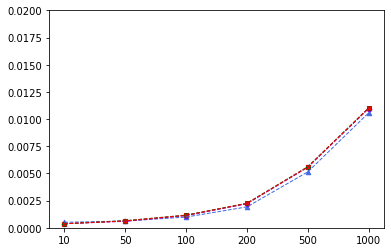

In [25]:
x_space = [0,1,2,3,4,5]


fig, ax = plt.subplots()
ax.plot(x_space, delta_RLGST_mean, 'royalblue', linestyle='--', lw=1)
ax.scatter(x_space, delta_RLGST_mean,marker='^', color='royalblue' ,s=20)

ax.plot(x_space, delta_GST_mean, color ='darkviolet', linestyle = '--', lw=1)
ax.scatter(x_space, delta_GST_mean, color='darkviolet', marker='o', s=20)

ax.plot(x_space, delta_GST_TP_mean, color='darkgreen',linestyle='--', lw=1)
ax.scatter(x_space, delta_GST_TP_mean, color = 'darkgreen', marker='s', s=20)

ax.plot(x_space, delta_GST_CPTP_mean, color='r', linestyle='--', lw=1)
ax.scatter(x_space, delta_GST_CPTP_mean,color='r', marker='x', s=20)

ax.set_ylim(0, 0.02);
ax.set_xticklabels(L_test_list)
ax.xaxis.set_major_locator(plt.FixedLocator(x_space))
#plt.yscale("log")
#plt.show()
